In [ ]:
pip install -U albumentations

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Concatenate
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random, time
import albumentations as A

In [ ]:
training_data = pd.read_csv('data.csv')

In [ ]:
# shuffle before accessing URLs; needed because
# take() or skip() on ShuffleDataset does not partition
# the entire dataset (e.g., there are shared samples)
indicies = list(range(0, len(training_data)))
random.shuffle(indicies)

# Converts URLs to tensors and prepends a batch axis. Takes dtype argument
def url_to_tensor(url, dtype=np.float32):
  t1 = tf.convert_to_tensor(io.imread(url), dtype= dtype)
  return t1[tf.newaxis, ...]

In [ ]:
"""
Was used for fetching images off URLs, ever since token expired I've been using my local copies
"""
# initialize x_train, y_train
init_label, init_example = training_data.iloc[indicies[0]]
x_train = url_to_tensor(init_example)
time.sleep(2)
y_train = url_to_tensor(init_label)

for index in indicies[1:]:
    label, example = training_data.iloc[index]
    time.sleep(2) # time delay to avoid fetching images too quickly
    t1 = url_to_tensor(example)
    x_train = tf.concat([t1, x_train], axis = 0)
    time.sleep(2)
    t2 = url_to_tensor(label)
    y_train = tf.concat([t2, y_train], axis = 0)

In [46]:
# Due to the volume of data involved (~1gb) files have been
# saved and are being served locally
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')

In [47]:
# normalize inputs/outputs
y_train = y_train/tf.reduce_max(y_train[0])
y_train = y_train[..., tf.newaxis]
x_train = x_train/tf.reduce_max(x_train[0])

In [48]:
DS_SIZE = len(x_train)
TENSOR_SHAPE = (len(x_train[0]), len(x_train[0]), 3)

# preprocess the training & validation set and 
# create Tensorflow Datasets for both

allDS = tf.data.Dataset.from_tensor_slices((x_train, y_train))
trainDS = allDS.take(int(0.6 * DS_SIZE))
validDS = allDS.skip(int(0.4 * DS_SIZE))

# cache, shuffle, batch & prefetch validation set
validDS = validDS.shuffle(1000).batch(8).prefetch(1)

In [ ]:
"""
Image Augmentation Pipeline No. 1: Tried ImageDataGenerator

Keras' ImageDataGenerator does not consistently jointly modify masks and images with the
same transformation when using flow()-- mixes up labels and hurts performance

datagen_args = dict(rotation_range=10,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.1)
"""

In [49]:
train_x = np.array([x for x, y in trainDS])
train_y = np.array([y for x, y in trainDS])

In [ ]:
"""
Image Augmentation Pipeline No. 2: Albumentations

ORIGINAL_DS_SIZE = len(train_x)

def augment(op, length, arr1, arr2):
  for cur_index in range(length):
    index = random.randint(0, length-1)
    augmented = op(image = arr1[index], mask = arr2[index])
    new_image, new_mask = augmented['image'], augmented['mask']
    new_image, new_mask = new_image[tf.newaxis, ...], new_mask[tf.newaxis, ...] 
    arr1 = np.concatenate((arr1, new_image))
    arr2 = np.concatenate((arr2, new_mask))
  return


flipandrotate = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5)]
)

transposeandflip = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5)]
)


augment(A.HorizontalFlip(p=1), ORIGINAL_DS_SIZE//10, train_x, train_y)
augment(A.VerticalFlip(p=1), ORIGINAL_DS_SIZE//10, train_x, train_y)
augment(A.RandomRotate90(p=1), ORIGINAL_DS_SIZE//10, train_x, train_y)
augment(A.Transpose(p=1), ORIGINAL_DS_SIZE//10, train_x, train_y)
augment(flipandrotate, ORIGINAL_DS_SIZE//10, train_x, train_y)
augment(transposeandflip, ORIGINAL_DS_SIZE//10, train_x, train_y)
"""

In [54]:
# Image Augmentation very expensive because of np.concatenates, for now cache augmented database locally, 
# in future bundle everything into a generator function
np.save('augx', train_x)
np.save('augy', train_y)

In [56]:
# create augmented trainDS
trainDS = tf.data.Dataset.from_tensor_slices((train_x, train_y))
trainDS = trainDS.cache().shuffle(1000).batch(8).prefetch(1)

In [62]:
# very quick Functional implementation

def unet():
  conv_settings = {"activation": "relu", "padding": "same"}
  upsampling_settings = {"strides": 2}
  
  input = tf.keras.Input(shape=(TENSOR_SHAPE))
  encoder = tf.keras.applications.mobilenet_v2.MobileNetV2(input_tensor = input,
                                                    input_shape=(TENSOR_SHAPE), 
                                                    include_top= False)
  encoder.trainable = False
  output = encoder.get_layer("block_16_expand_relu").output
  output = Conv2D(768, 3, **conv_settings)(output)
  output = Dropout(0.50)(output)
  output = Conv2D(768, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)

  output = Conv2DTranspose(384, 2, **upsampling_settings)(output)
  output = Concatenate()([encoder.get_layer("block_10_expand_relu").output, output])
  output = Conv2D(384, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  output = Conv2D(384, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)

  output = Conv2DTranspose(192, 2, **upsampling_settings)(output)
  output = Concatenate()([encoder.get_layer("block_6_expand_relu").output, output])
  output = Conv2D(192, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  output = Conv2D(192, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)

  output = Conv2DTranspose(96, 2, **upsampling_settings)(output)
  output = Conv2D(96, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  output = Conv2D(96, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)

  output = Conv2DTranspose(96, 2, **upsampling_settings)(output)
  output = Concatenate()([encoder.get_layer("block_1_expand_relu").output, output])
  output = Conv2D(96, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  output = Conv2D(96, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  
  output = Conv2DTranspose(96, 2, **upsampling_settings)(output)
  output = Conv2D(1, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  output = Conv2D(1, 3, **conv_settings)(output)
  output = Dropout(0.40)(output)
  output = Conv2D(1, 1, activation="sigmoid")(output)

  return tf.keras.models.Model(input, output)

In [63]:
# loss function: Focal Tversky loss. Taken from code published by
# primary author of the "A Novel Focal Tversky Loss Function..." (2018) paper
smooth = 1
def tversky(y_true, y_pred):
    y_true_pos = tf.keras.backend.flatten(y_true)
    y_pred_pos = tf.keras.backend.flatten(y_pred)
    true_pos = tf.keras.backend.sum(y_true_pos * y_pred_pos)
    false_neg = tf.keras.backend.sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.keras.backend.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return ((true_pos + smooth)/(true_pos + alpha*false_neg 
                                 + (1-alpha)*false_pos + smooth))
def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 4/3
    return tf.keras.backend.pow((1-pt_1), gamma)

# ---

loss_object = focal_tversky

# optimizer
my_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# checkpointing
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='../checkpoint/')

# create an instance of the model
unet_model = unet()
unet_model.compile(optimizer= my_optimizer,
                   metrics = [tf.keras.metrics.Precision(), 
                              tf.keras.metrics.Recall(),
                              tf.keras.metrics.MeanIoU(num_classes=2)],
                   loss = focal_tversky)

my_callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath=".../tmp",
    save_weights_only=True,
    monitor='val_precision',
    mode='max',
    save_best_only=True)]
unet_model.fit(trainDS, epochs= 500, validation_data= validDS, steps_per_epoch=55)


Epoch 1/500
55/55 [==============================] - 23s 354ms/step - loss: 0.5787 - precision_3: 0.1949 - recall_3: 0.8329 - mean_io_u_3: 0.3987 - val_loss: 0.5587 - val_precision_3: 0.2131 - val_recall_3: 1.0000 - val_mean_io_u_3: 0.3935
Epoch 2/500
55/55 [==============================] - 18s 335ms/step - loss: 0.5682 - precision_3: 0.2019 - recall_3: 1.0000 - mean_io_u_3: 0.3991 - val_loss: 0.5560 - val_precision_3: 0.2139 - val_recall_3: 1.0000 - val_mean_io_u_3: 0.3935
Epoch 3/500
55/55 [==============================] - 18s 334ms/step - loss: 0.5676 - precision_3: 0.2024 - recall_3: 0.9998 - mean_io_u_3: 0.3990 - val_loss: 0.5536 - val_precision_3: 0.2198 - val_recall_3: 0.9999 - val_mean_io_u_3: 0.3935
Epoch 4/500
55/55 [==============================] - 18s 333ms/step - loss: 0.5684 - precision_3: 0.2021 - recall_3: 0.9940 - mean_io_u_3: 0.4001 - val_loss: 0.5555 - val_precision_3: 0.2143 - val_recall_3: 1.0000 - val_mean_io_u_3: 0.3935
Epoch 5/500
55/55 [=====================

In [64]:
unet_model.save('unet-model.h5')

TensorShape([512, 512])

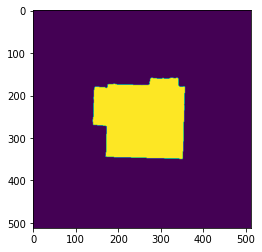

In [74]:
plt.imshow(unet_model(x_train[0:2])[0, :, :, 0])
(unet_model(x_train[0:2])[1, :, :, 0]).shape

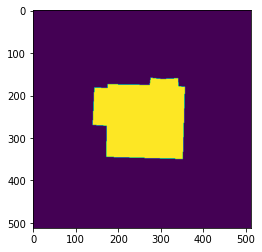

In [75]:
plt.imshow(y_train[0, :, :, 0]/255)

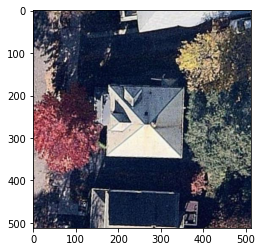

In [79]:
plt.imshow(x_train[0])

In [ ]:
# Initially I wrote this using the Imperative API-- big mistake. 

"""
class UNetBlock(tf.keras.layers.Layer):
  def __init__(self,
               filters,  
               kernel_size=3,
               transpose_kernel=2, 
               dropout = 0.5,
               **kwargs):
    conv_settings = {"activation": "relu", "padding": "same"}
    upsampling_settings = {"strides": 2}

    super().__init__(**kwargs)
    self.conv1 = Conv2D(filters, kernel_size, **conv_settings)
    self.drop1 = Dropout(dropout)
    self.conv2 = Conv2D(filters, 3, **conv_settings)
    self.drop2 = Dropout(dropout)
    self.upconv1 = Conv2DTranspose(filters/2, 
                                   transpose_kernel, 
                                 **upsampling_settings)
    self.trainable = True

  def call(self, input):
    input = self.conv1(input)
    input = self.drop1(input)
    input = self.conv2(input)
    input = self.drop2(input)
    input = self.upconv1(input)
    return input


@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # we have dropout layers so training = True
    predictions = unet(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, unet.trainable_variables)
  optimizer.apply_gradients(zip(gradients, unet.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)
  train_recall(labels, predictions)
  train_precision(labels, predictions)

So I realized way too late that Tensorflow doesn't seem to support any form
# of concatenation with the Subclassing API-- trying to use elements of the Keras Functional 
# API throws bizarre errors
# My u-net thus does not include high resolution features from the contracting path
# however, I indicate what concatenations I would otherwise make, and a possible workaround

class UNet(tf.keras.Model):
  def __init__(self, **kwargs):
    # strictly speaking the u-net should have valid padding, but
    # same padding is needed because we want same output size as input
    conv_settings = {"activation": "relu", "padding": "same"}
    upsampling_settings = {"strides": 2}

    super().__init__(**kwargs)
    self.encoder = encoder
    self.conv1 = Conv2D(768, 3, **conv_settings)
    self.drop1 = Dropout(0.50)
    self.conv2 = Conv2D(768, 3, **conv_settings)
    self.drop2 = Dropout(0.50)
    self.upconv1 = Conv2DTranspose(384, 2, **upsampling_settings)

    # workaround: use model as wrapper for Concatenate()
    # self.concat1Model = tf.keras.Model()

    self.unet_block1 = UNetBlock(384)
    self.unet_block2 = UNetBloc#k(192)
    self.unet_block3 = UNetBlock(96)
    self.unet_block4 = UNetBlock(48)
    self.conv3 = Conv2D(64, 3, **conv_settings)
    self.drop3 = Dropout(0.50)
    self.conv4 = Conv2D(64, 3, **conv_settings)
    self.drop4 = Dropout(0.50)
    self.conv5 = Conv2D(1, 1, activation="sigmoid") # filters = 2 in u-net paper
    
  def call(self, input):
    input = self.encoder(input)
    input = self.conv1(input)
    input = self.drop1(input)
    input = self.conv2(input)
    input = self.drop2(input)
    input = self.upconv1(input)

    # tried to build keras model and use it to wrap the symbolic logic
    # of Concatenate(), and this works!-- but building a model at every call
    # to call() quickly causes an OOM error with ~ 15 gb GPU.
    #
    # input1 = input.shape
    # concat1 = tf.keras.layers.Concatenate()([input, 
    # encoder.get_layer("block_10_expand_relu").output])
    # self.concat1Model = tf.keras.Model(input1, concat1)
    # input = self.concat1Model(input)

    input = self.unet_block1(input)

    # <- concatenate input with block_6_expand_relu- >
    input = self.unet_block2(input)

    # <- concatenate input with block_1_expand_relu- >
    input = self.unet_block3(input)

    input = self.unet_block4(input)
    input = self.conv3(input)
    input = self.drop3(input)
    input = self.conv4(input) 
    input = self.drop4(input)
    input = self.conv5(input)
    return input

@tf.function
def test_step(images, labels):
  predictions = unet(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_recall(labels, predictions)
  test_precision(labels, predictions)
  test_IoU.update_state(labels, predictions)

EPOCHS = 700
BATCHES_IN_EPOCH = 18

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_IoU.reset_states()
  test_precision.reset_states()
  test_recall.reset_states()

  for batch in range(BATCHES_IN_EPOCH):
    images, labels = next(training_generator)
    train_step(images, labels)

  for valid_images, valid_labels in validDS:
    test_step(valid_images, valid_labels)


  print(
    f'E:{epoch + 1}, '
    f'T_Loss: {train_loss.result()}, '
    f'Precision: {train_precision.result()}, '
    f'Recall: {train_recall.result()}, '
    f'Test_Precision: {test_precision.result()}, '
    f'Test_Recall: {test_recall.result()}, '
    f'Test_IoU: {test_IoU.result()}'
  )

  # metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
train_precision = tf.keras.metrics.Precision(name="train_precision")
train_recall = tf.keras.metrics.Recall(name="train_recall")

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_IoU = tf.keras.metrics.MeanIoU(num_classes=2)
test_precision = tf.keras.metrics.Precision(name= "test_precision")
test_recall = tf.keras.metrics.Recall(name= "test_recall")

  """

In [81]:
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 256, 256, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 256, 256, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 256, 256, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
unet.save("ImperativeAPIModel")

INFO:tensorflow:Assets written to: ImperativeAPIModel/assets


INFO:tensorflow:Assets written to: ImperativeAPIModel/assets
